In [1]:
from utils import IbexChipWhisperer, DataGenerator, DataWrangler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import pandas as pd

In [2]:
dw = DataWrangler()

# Data Metrics

In [3]:
def dual_log_plot(x, y, x_label='Software', y_label='Instruction Count', 
                           title='Regular vs Logarithmic Scale', 
                           figsize=(10, 6), save_path=None):
    """
    Plot values in both regular and logarithmic scale using dual y-axes.
    
    Parameters:
    -----------
    x : list
        List of x-axis labels
    y : list
        List of y-axis values
    x_label : str, optional
        Label for x-axis (default: 'Software')
    y_label : str, optional
        Base label for y-axis (default: 'Instruction Count')
    title : str, optional
        Plot title (default: 'Regular vs Logarithmic Scale')
    figsize : tuple, optional
        Figure size as (width, height) in inches (default: (10, 6))
    save_path : str, optional
        If provided, save the figure to this path (default: None)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Calculate logarithmic values
    ly = np.log(y)
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=figsize)
    
    # Plot regular scale data
    ax1.bar(x, y, color='blue', alpha=0.6, label='Regular')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label, color='blue')
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create second y-axis and plot logarithmic scale data
    ax2 = ax1.twinx()
    ax2.plot(x, ly, 'ro-', linewidth=2, label='Logarithmic')
    ax2.set_ylabel(f'ln({y_label})', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Add title and adjust layout
    plt.title(title)
    plt.tight_layout()
    
    # Save figure if requested
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig, ax1, ax2

def plot_grid(data_dict, filter=None, rows=None, cols=None, figsize=(18, 12), 
              main_title="Instruction Counts by Software", 
              sort_by_value=True, save_path=None):
    """
    Create a grid of instruction count plots from a dictionary of count dictionaries.
    
    Parameters:
    -----------
    data_dict : dict of dicts
        Dictionary where keys are software names and values are dictionaries 
        of instruction:count pairs
    rows : int, optional
        Number of rows in the grid (calculated automatically if None)
    cols : int, optional
        Number of columns in the grid (calculated automatically if None)
    figsize : tuple, optional
        Figure size as (width, height) in inches (default: (18, 12))
    main_title : str, optional
        Main title for the entire figure (default: "Instruction Counts by Software")
    sort_by_value : bool, optional
        Whether to sort instructions by count value (default: True)
    save_path : str, optional
        If provided, save the figure to this path (default: None)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    if filter:
        data_dict = data_dict.copy()
        data_dict = {key:val for key,val in data_dict.items() if filter in key}
    
    n_plots = len(data_dict)
    
    # Calculate grid dimensions if not specified
    if rows is None and cols is None:
        cols = min(3, n_plots)  # Default to 3 columns max
        rows = (n_plots + cols - 1) // cols
    elif rows is None:
        rows = (n_plots + cols - 1) // cols
    elif cols is None:
        cols = (n_plots + rows - 1) // rows
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=1.5)
    
    # Create each subplot
    for i, (software_name, count_dict) in enumerate(data_dict.items()):
        if i >= rows * cols:
            print(f"Warning: Only showing {rows * cols} plots out of {n_plots}")
            break
            
        row, col = i // cols, i % cols
        
        # Sort the data
        if sort_by_value:
            # Sort by count (descending)
            sorted_items = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
        else:
            # Sort by instruction name
            sorted_items = sorted(count_dict.items())
        
        # Extract x and y values
        x = [item[0] for item in sorted_items]
        y = [item[1] for item in sorted_items]
        
        # Create subplot
        ax1 = fig.add_subplot(gs[row, col])
        
        # Calculate logarithmic values for non-zero counts
        # Use a small value (1) for zero counts to avoid log(0) error
        log_y = [np.log(val) if val > 0 else 0 for val in y]
        
        # Plot regular scale data
        ax1.bar(x, y, color='blue', alpha=0.6, label='Regular')
        ax1.set_xlabel('Instruction')
        ax1.set_ylabel('Count', color='blue')
        ax1.tick_params(axis='x', rotation=90)
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Create second y-axis and plot logarithmic scale data
        ax2 = ax1.twinx()
        ax2.plot(x, log_y, 'ro-', linewidth=2, label='Logarithmic')
        ax2.set_ylabel('ln(Count)', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add title
        ax1.set_title(software_name)
        
        # Add legend (only for the first plot to save space)
        if i == 0:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Add main title if provided
    if main_title:
        fig.suptitle(main_title, fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure if requested
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig

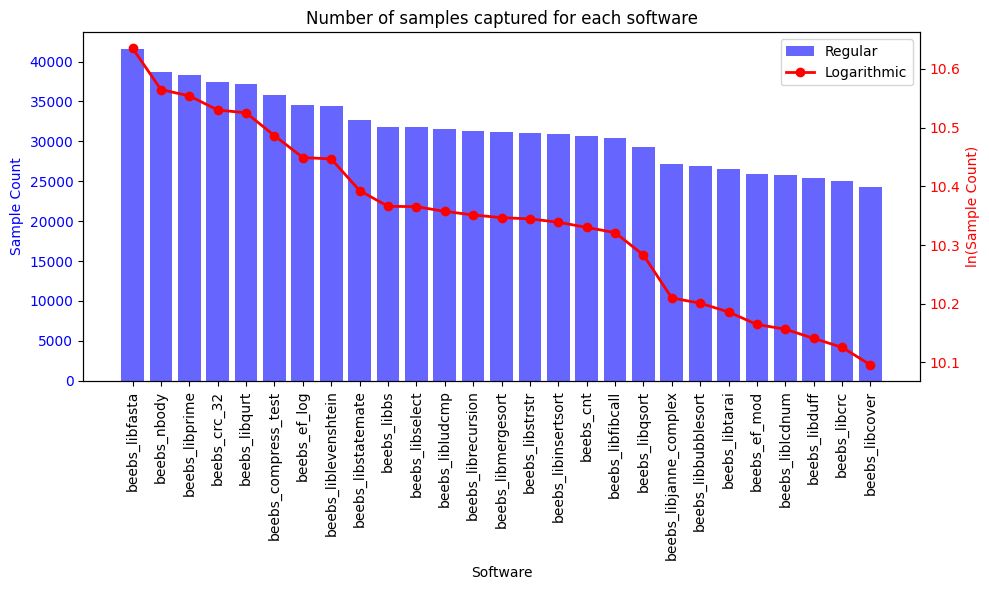

In [4]:
pairs = dw.get_trace_counts()
labelFilter = lambda pairs, filt: zip(*[pair for pair in pairs if filt in pair[0]])
x, y = labelFilter(pairs, "beebs")
fig, ax1, ax2 = dual_log_plot(x,y,y_label="Sample Count", title="Number of samples captured for each software")

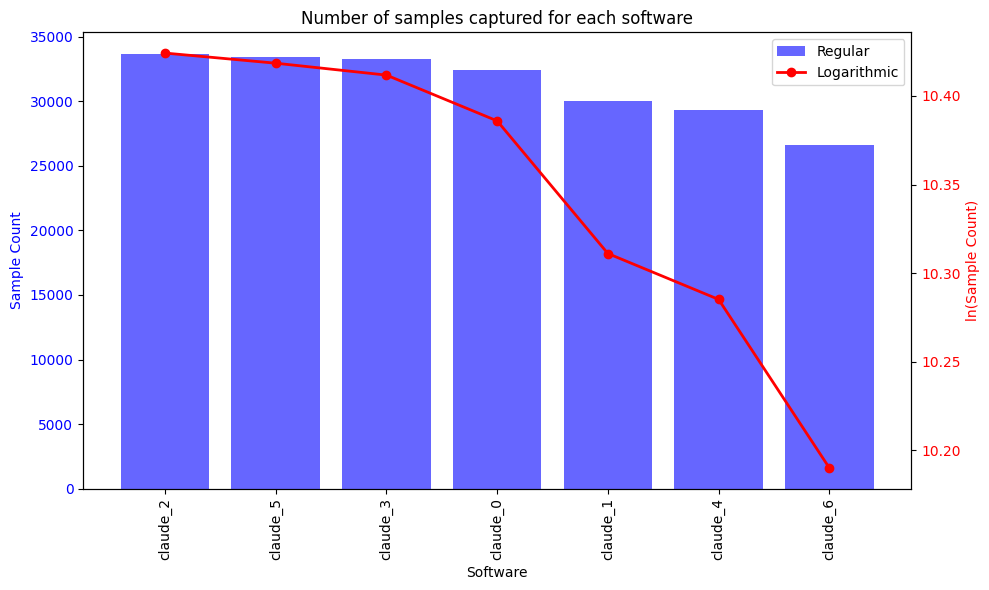

In [5]:
x, y = labelFilter(pairs, "claude")
fig, ax1, ax2 = dual_log_plot(x,y,y_label="Sample Count", title="Number of samples captured for each software")

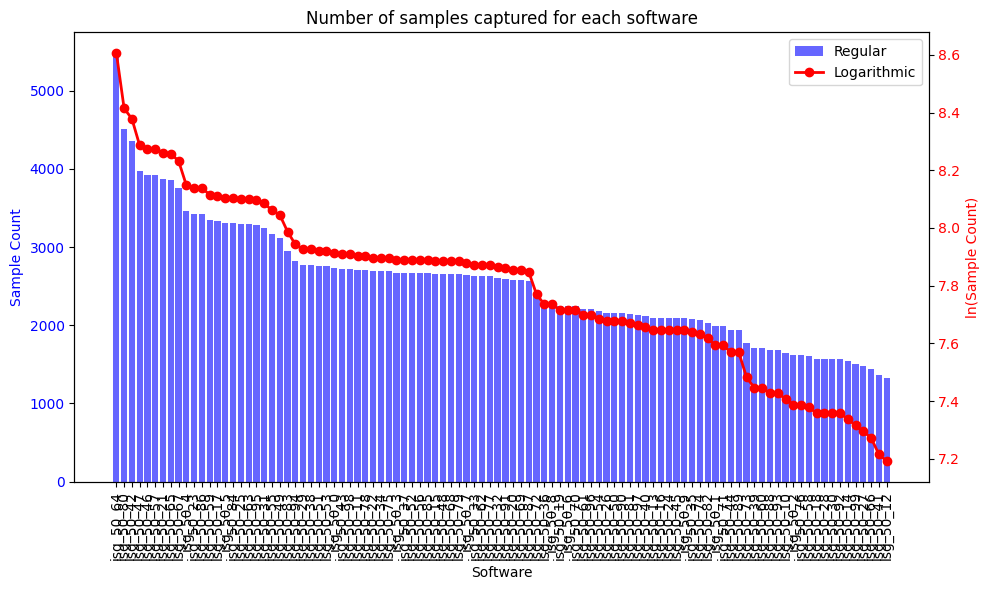

In [6]:
x, y = labelFilter(pairs, "isg_50")
fig, ax1, ax2 = dual_log_plot(x,y,y_label="Sample Count", title="Number of samples captured for each software")

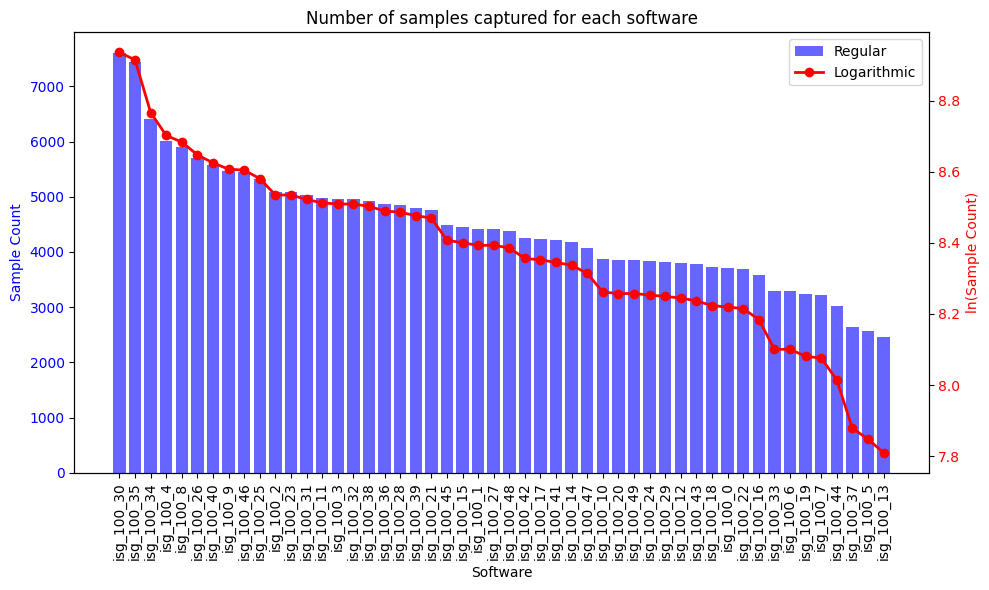

In [7]:
x, y = labelFilter(pairs, "isg_100")
fig, ax1, ax2 = dual_log_plot(x,y,y_label="Sample Count", title="Number of samples captured for each software")

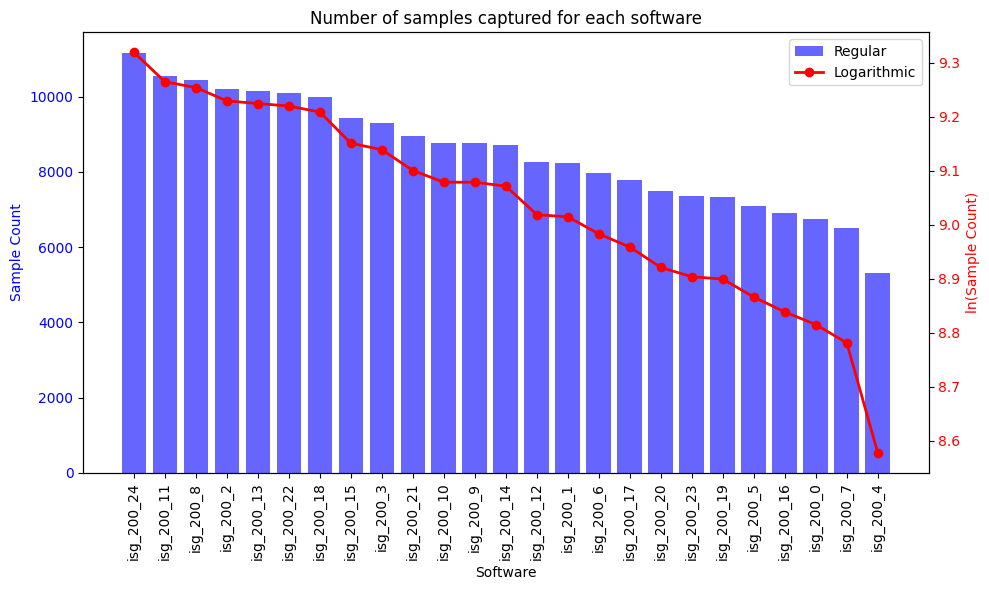

In [8]:
x, y = labelFilter(pairs, "isg_200")
fig, ax1, ax2 = dual_log_plot(x,y,y_label="Sample Count", title="Number of samples captured for each software")

In [9]:
x, y = zip(*pairs)
trace_length_dict = {key: val for key, val in zip(x,y)}

In [10]:
for key, val in trace_length_dict.items():
    if "isg" in key:
        print(f"{key}: {val}")

isg_200_24: 11152
isg_200_11: 10560
isg_200_8: 10448
isg_200_2: 10192
isg_200_13: 10144
isg_200_22: 10096
isg_200_18: 9984
isg_200_15: 9424
isg_200_3: 9312
isg_200_21: 8960
isg_200_10: 8768
isg_200_9: 8768
isg_200_14: 8704
isg_200_12: 8256
isg_200_1: 8224
isg_200_6: 7968
isg_200_17: 7776
isg_100_30: 7600
isg_200_20: 7488
isg_100_35: 7440
isg_200_23: 7360
isg_200_19: 7328
isg_25_193: 7328
isg_200_5: 7088
isg_200_16: 6896
isg_200_0: 6736
isg_200_7: 6512
isg_100_34: 6416
isg_100_4: 6016
isg_100_8: 5904
isg_100_26: 5696
isg_100_40: 5568
isg_100_9: 5472
isg_50_64: 5472
isg_100_46: 5456
isg_100_25: 5328
isg_200_4: 5312
isg_100_2: 5088
isg_100_23: 5088
isg_25_119: 5072
isg_25_224: 5040
isg_100_31: 5024
isg_25_186: 4992
isg_25_339: 4992
isg_25_78: 4992
isg_100_11: 4976
isg_100_3: 4960
isg_100_32: 4960
isg_25_169: 4944
isg_100_38: 4928
isg_100_36: 4864
isg_100_28: 4848
isg_100_39: 4800
isg_100_21: 4768
isg_50_80: 4512
isg_25_134: 4496
isg_100_45: 4480
isg_25_289: 4480
isg_25_125: 4464
isg_25_18

In [11]:
result = dw.parse_labels(source='spike')  # source='spike' or source='gdb'
instruction_line_dict = result['instruction_lines']
instruction_dict = result['instructions'] 
count_dict = result['counts']

/tmp/ipykernel_171928/1447566223.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


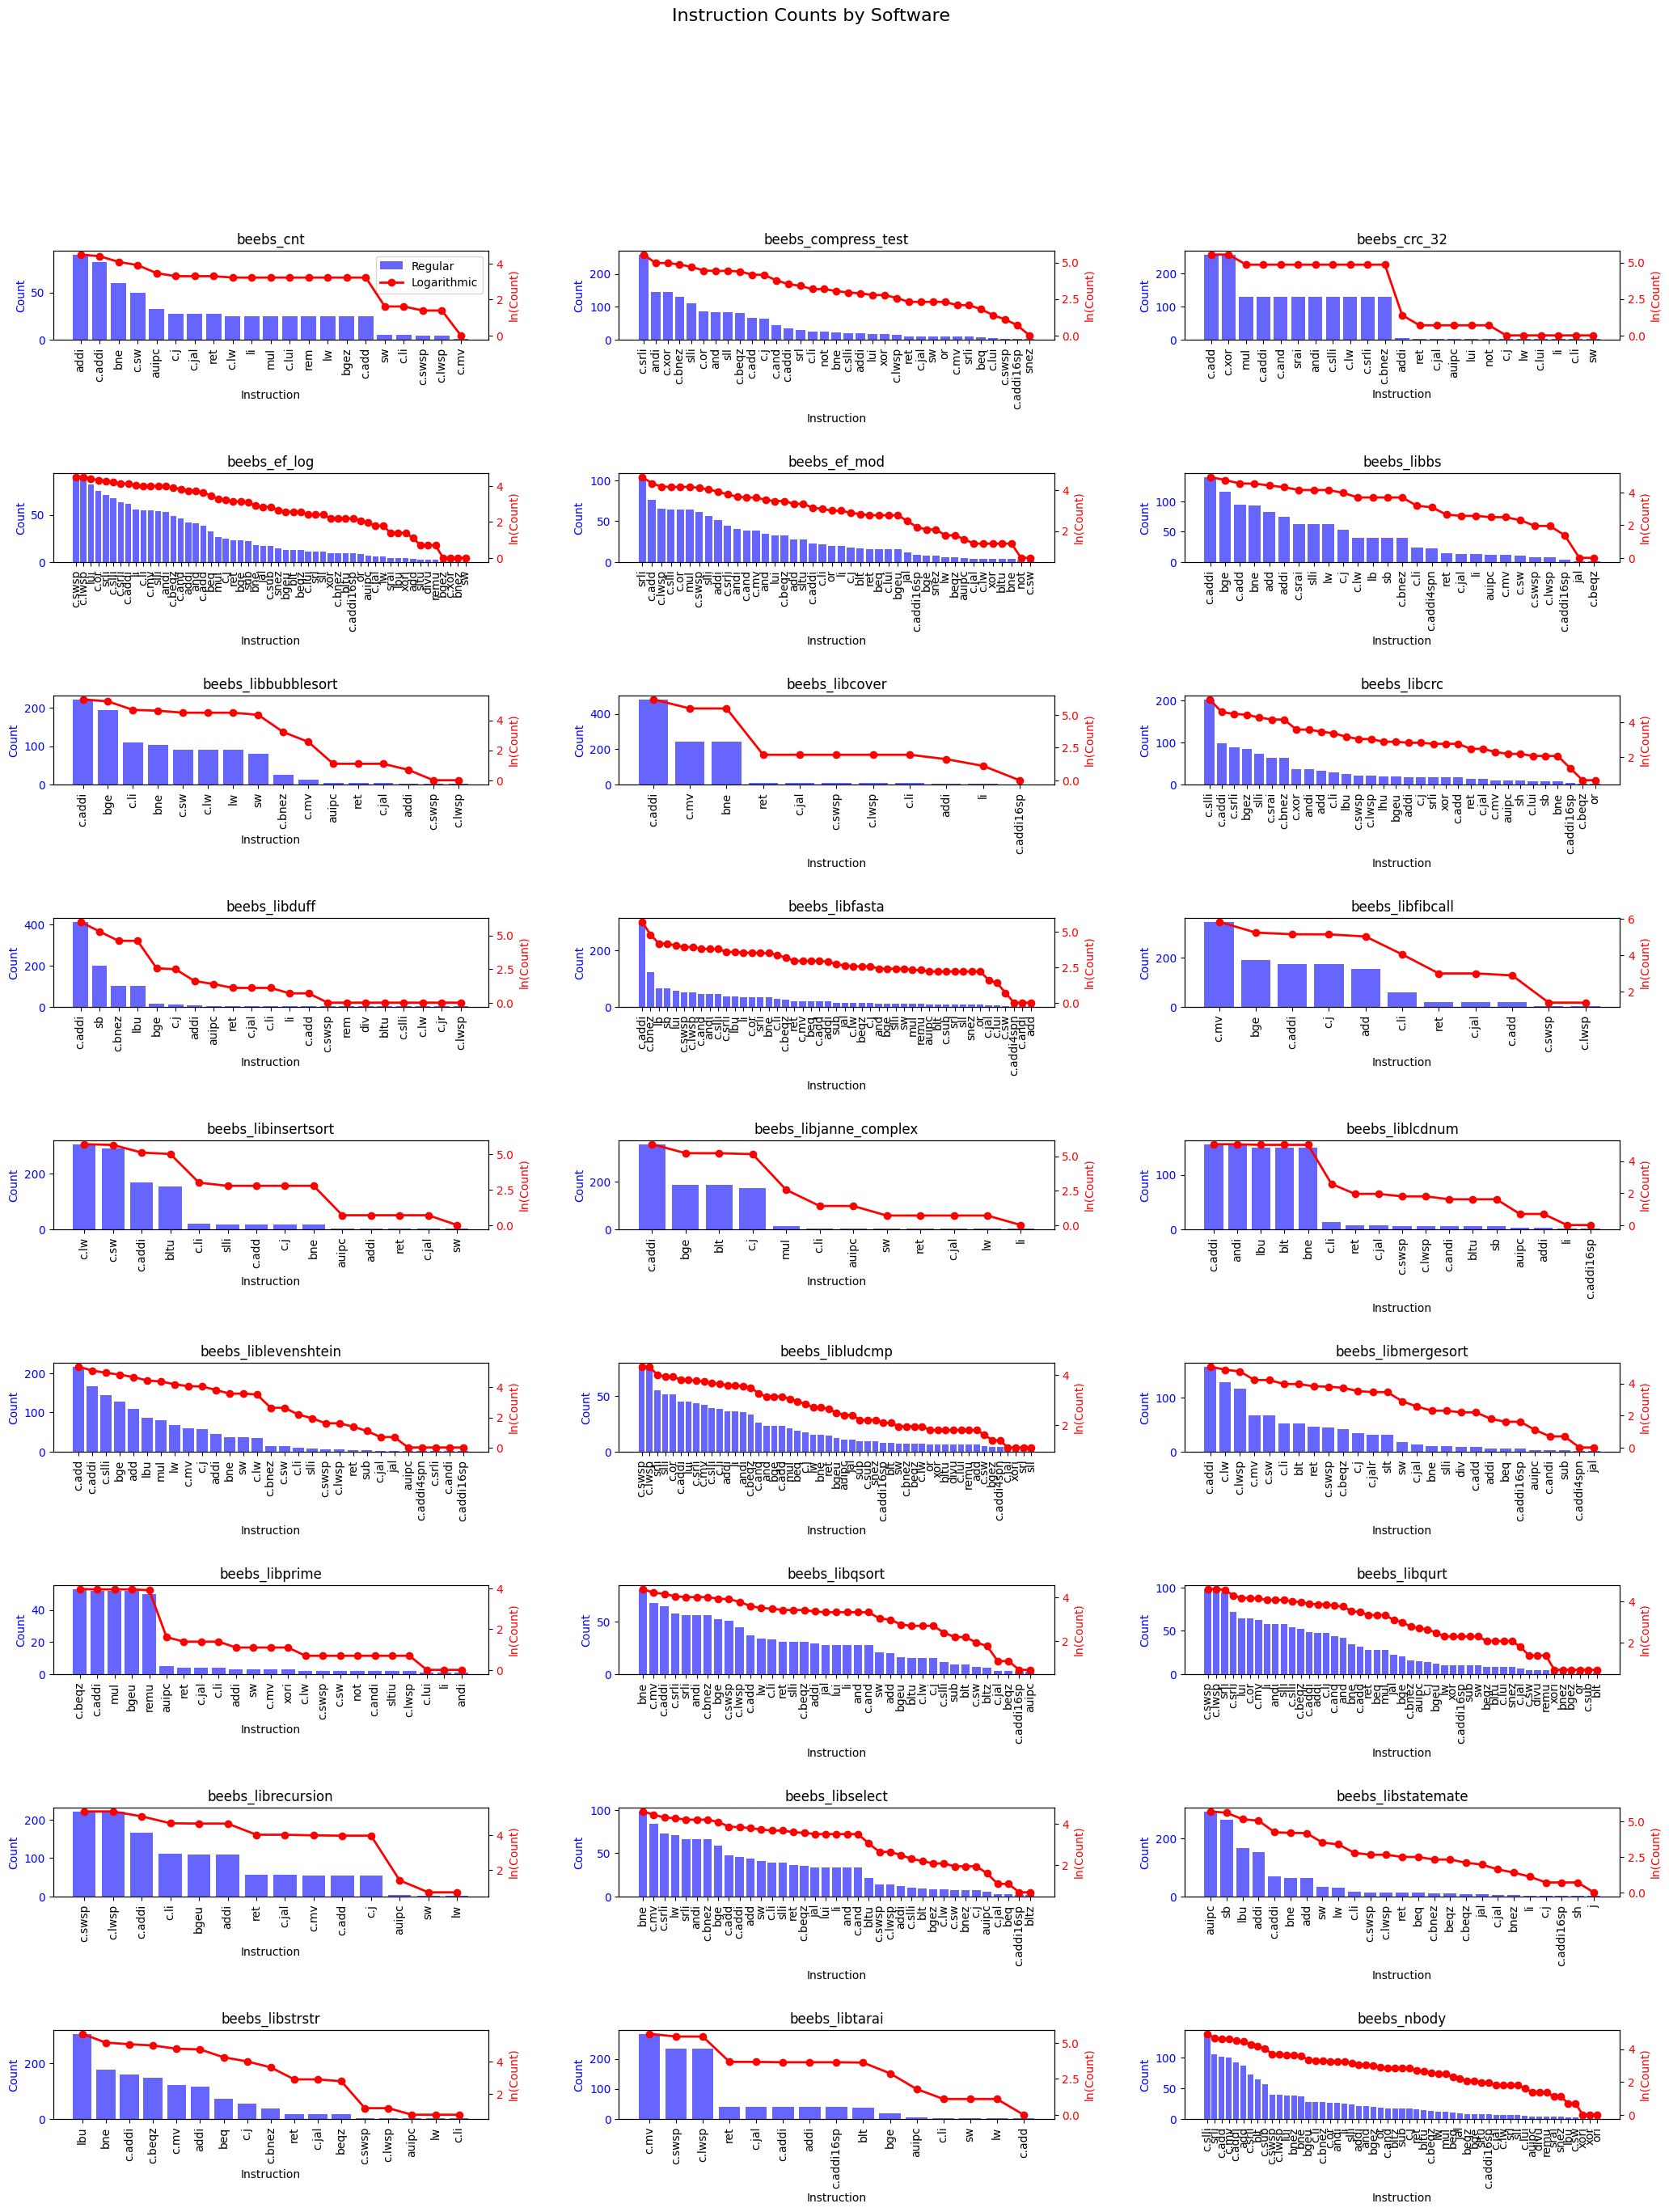

In [12]:
fig = plot_grid(count_dict, "beebs", figsize=(25, 30))

/tmp/ipykernel_171928/1447566223.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


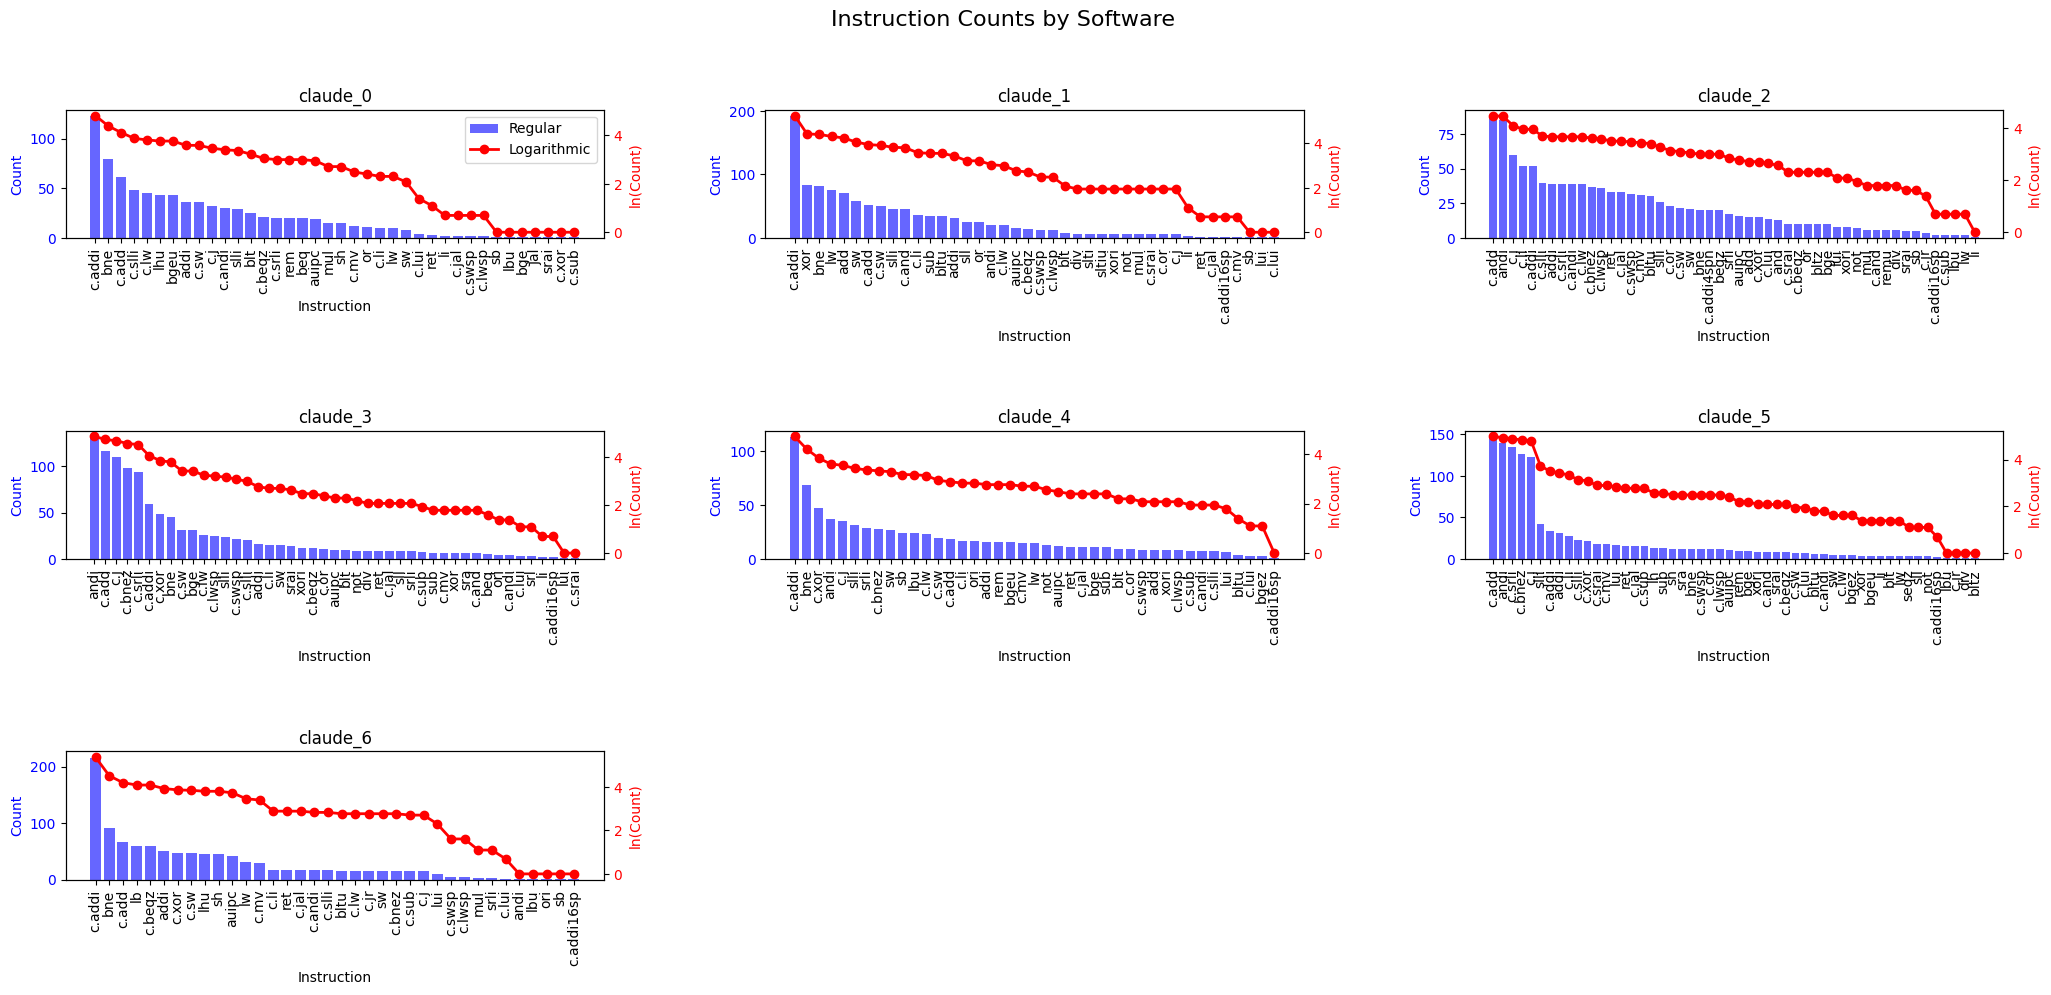

In [13]:
fig = plot_grid(count_dict, "claude", figsize=(25, 10))

/tmp/ipykernel_171928/1447566223.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


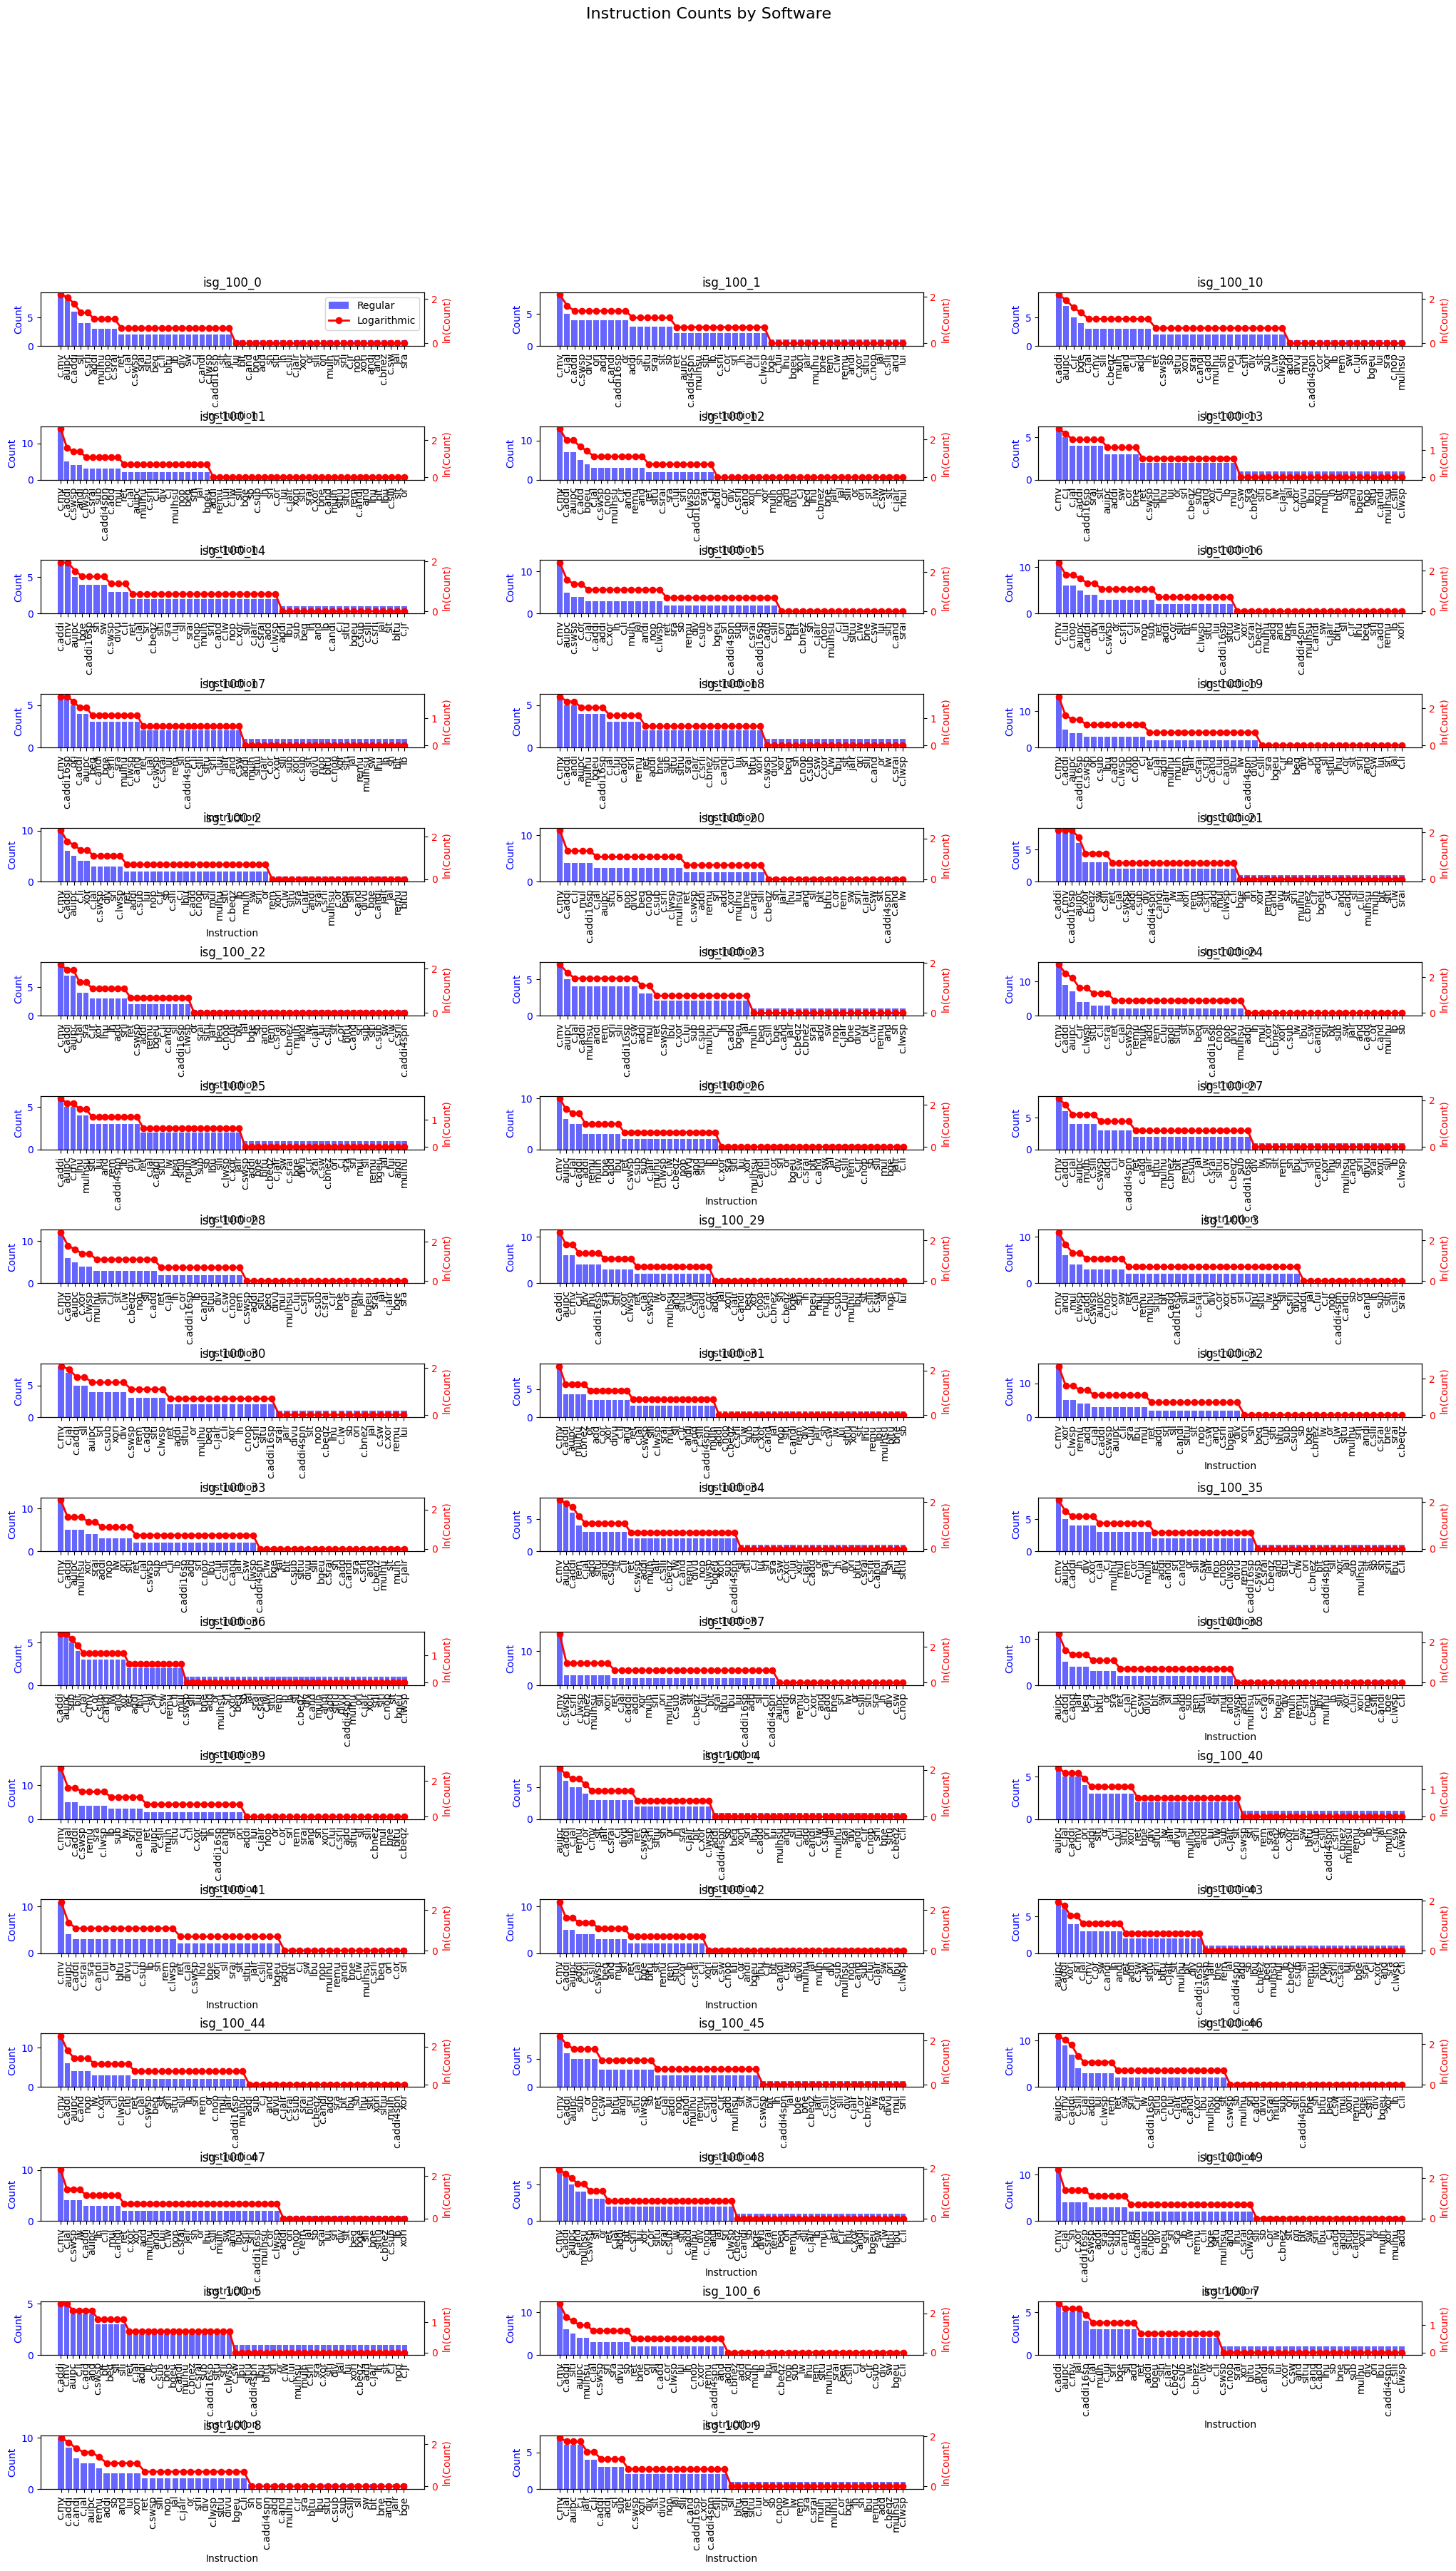

In [14]:
fig = plot_grid(count_dict, "isg_100", figsize=(25, 40))

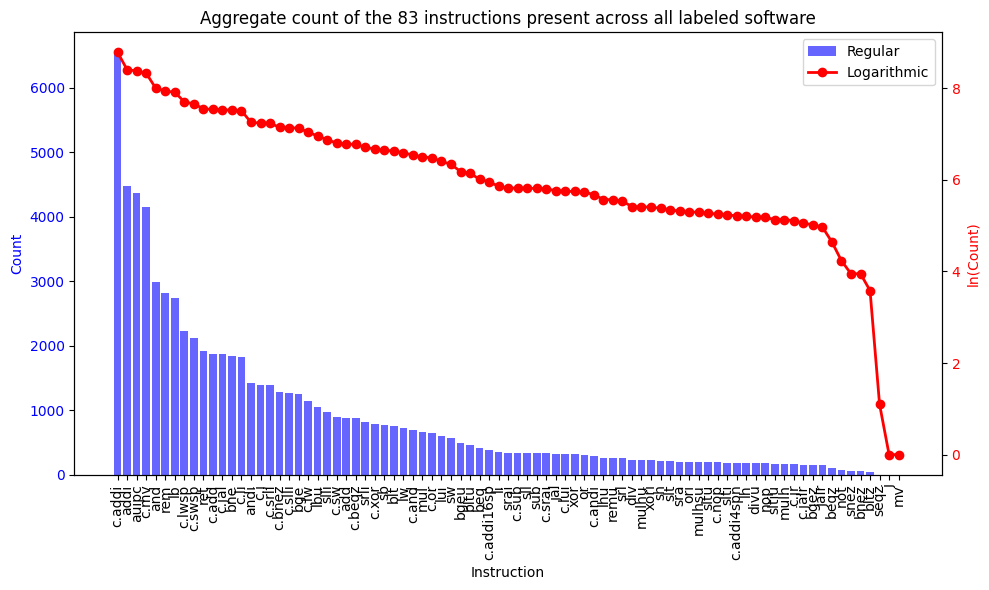

In [15]:
agr_dct = dw.aggregate_counts(count_dict)

x,y = zip(*sorted(agr_dct.items(), key=lambda x: x[1], reverse=True))
fig, ax1, ax2 = dual_log_plot(x,y,x_label="Instruction",y_label="Count", title=f"Aggregate count of the {len(x)} instructions present across all labeled software")

In [16]:
agr_dct.keys()

dict_keys(['auipc', 'sw', 'addi', 'c.j', 'c.addi', 'c.swsp', 'c.mv', 'c.jal', 'c.lw', 'li', 'mul', 'c.lui', 'rem', 'c.sw', 'ret', 'bne', 'c.lwsp', 'c.li', 'lw', 'bgez', 'c.add', 'lui', 'c.bnez', 'andi', 'c.beqz', 'c.srli', 'c.or', 'c.slli', 'snez', 'and', 'sll', 'beq', 'not', 'slli', 'c.xor', 'c.and', 'srl', 'xor', 'srli', 'c.addi16sp', 'or', 'srai', 'jal', 'c.sub', 'bgeu', 'sltu', 'lbu', 'sub', 'blt', 'bge', 'xori', 'bltu', 'beqz', 'divu', 'remu', 'add', 'bnez', 'c.srai', 'c.addi4spn', 'lb', 'sb', 'lhu', 'sh', 'div', 'c.jr', 'c.andi', 'c.jalr', 'slt', 'sltiu', 'bltz', 'j', 'ori', 'slti', 'sra', 'lh', 'seqz', 'mulhu', 'c.nop', 'mulh', 'nop', 'jalr', 'mulhsu', 'mv'])

Number of unique instructions: 83
Summary Statistics:
Average Ratio: 0.021
Maximum Ratio: 0.045 (beebs_ef_mod)
Minimum Ratio: 0.005 (isg_25_193)


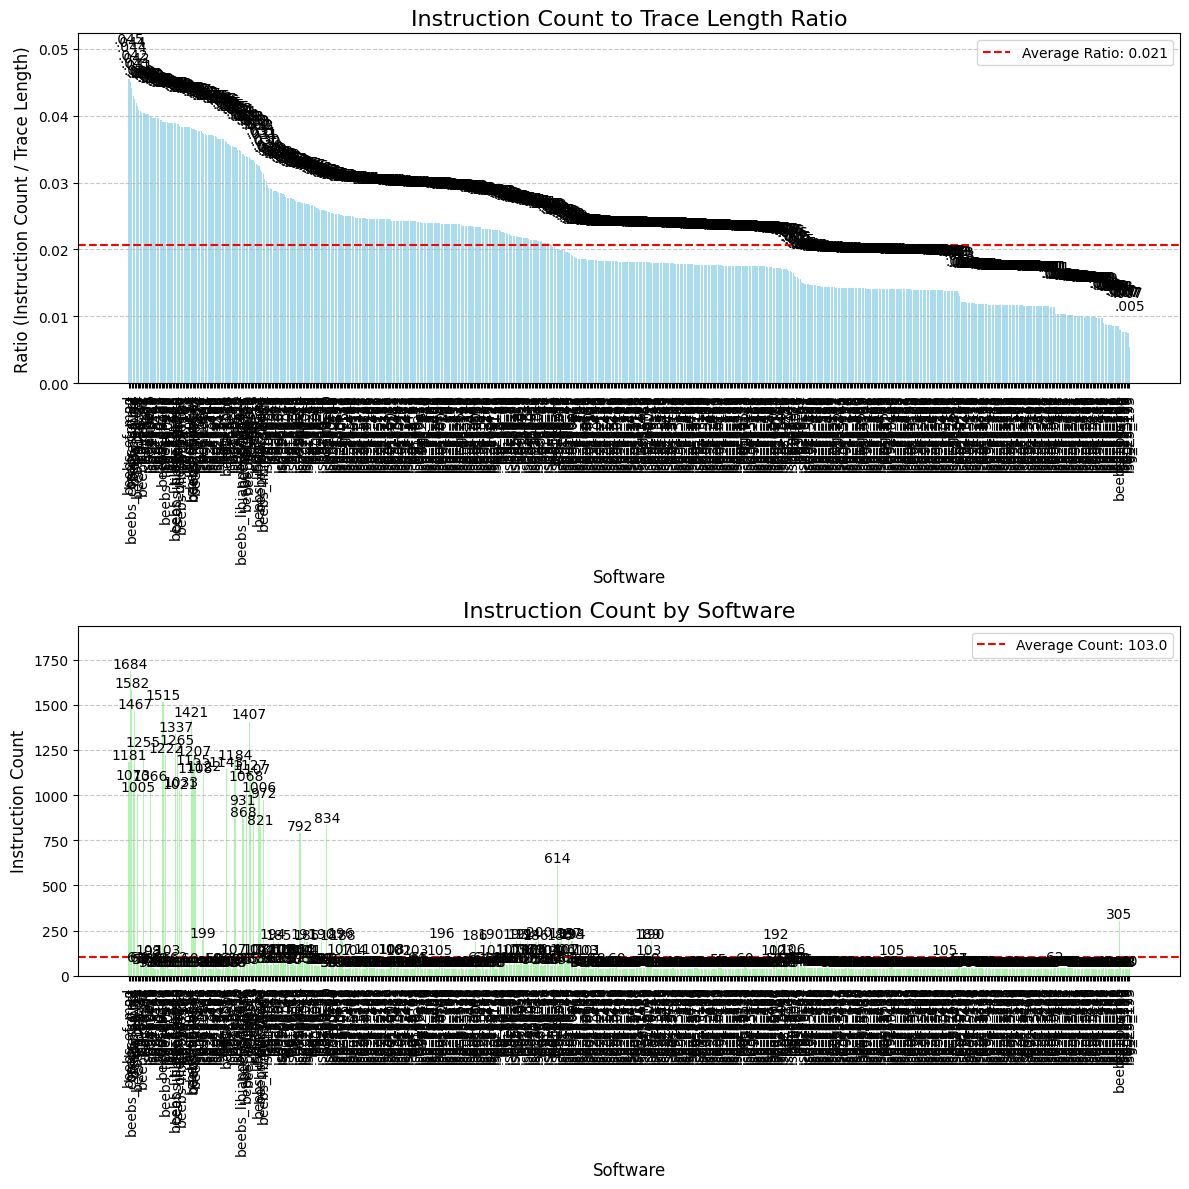

In [17]:
print(f"Number of unique instructions: {len(agr_dct)}")
# Get instruction count : trace length ratio
ratio_dict = {}
for sw in count_dict.keys():
    instr_count = sum(count_dict[sw].values())
    trace_len = trace_length_dict[sw]
    ratio = instr_count / trace_len
    ratio_dict[sw] = {
        'instruction_count': instr_count,
        'trace_length': trace_len,
        'ratio': ratio
    }
# Create and sort results list for better visualization
ratio_results = [{'software': sw, **data} for sw, data in ratio_dict.items()]
ratio_results.sort(key=lambda x: x['ratio'], reverse=True)
# Print only summary statistics
ratios = [r['ratio'] for r in ratio_results]
avg_ratio = sum(ratios) / len(ratios)
max_ratio = max(ratios)
min_ratio = min(ratios)
print("Summary Statistics:")
print(f"Average Ratio: {avg_ratio:.3f}")
print(f"Maximum Ratio: {max_ratio:.3f} ({ratio_results[0]['software']})")
print(f"Minimum Ratio: {min_ratio:.3f} ({ratio_results[-1]['software']})")

# Create visualization with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Ratio bars
software_names = [r['software'] for r in ratio_results]
ratio_values = [r['ratio'] for r in ratio_results]
instr_count_values = [r['instruction_count'] for r in ratio_results]  # Fixed syntax error here

# Create bar plot with custom colors for ratios
bars1 = ax1.bar(software_names, ratio_values, color='skyblue', alpha=0.7)
# Add a horizontal line for the average ratio
ax1.axhline(y=avg_ratio, color='red', linestyle='--', label=f'Average Ratio: {avg_ratio:.3f}')
# Add data labels on top of each bar with 3 decimal places
for bar, ratio in zip(bars1, ratio_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'.{str(ratio)[2:5]}', ha='center', va='bottom')
# Customize the first plot
ax1.set_title('Instruction Count to Trace Length Ratio', fontsize=16)
ax1.set_xlabel('Software', fontsize=12)
ax1.set_ylabel('Ratio (Instruction Count / Trace Length)', fontsize=12)
ax1.set_ylim(0, max(ratio_values) * 1.15)  # Add some space for labels
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()
# Rotate x-axis labels 90 degrees
ax1.tick_params(axis='x', rotation=90)

# Plot 2: Instruction count bars
bars2 = ax2.bar(software_names, instr_count_values, color='lightgreen', alpha=0.7)
# Add data labels on top of each bar
avg_count = sum(instr_count_values) / len(instr_count_values)
ax2.axhline(y=avg_count, color='red', linestyle='--', label=f'Average Count: {avg_count:.1f}')
for bar, count in zip(bars2, instr_count_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{count}', ha='center', va='bottom')
# Customize the second plot
ax2.set_title('Instruction Count by Software', fontsize=16)
ax2.set_xlabel('Software', fontsize=12)
ax2.set_ylabel('Instruction Count', fontsize=12)
ax2.set_ylim(0, max(instr_count_values) * 1.15)  # Add some space for labels
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()
# Rotate x-axis labels 90 degrees
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
# Display the plot
plt.show()

The instruction sequence length has no bearing on its importance during training, and long sequences slow down the model a lot.
So it is desirable to have approximately equal length instruction sequences, to avoid biasing towards "shorter" pieces of software
And shorter instruction sequences, to accelerate training.

In [18]:
target_instruction_length = 1000
target_trace_length = target_instruction_length / avg_ratio
print(f"Target trace length: {int(target_trace_length)} to achieve average instruction sequence length {target_instruction_length}")

Target trace length: 48464 to achieve average instruction sequence length 1000


# Dataset Generation

Attempt to split the dataset reasonably, so that add heavy traces are in the test set.

## Splitting

First lets analyze and split the data

In [19]:
import numpy as np
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt

def get_optimal_split(count_dict: Dict[str, Dict[str, int]], 
                      target_split: Tuple[float, float, float] = (0.7, 0.1, 0.2),
                      max_search_steps: int = 100,
                      tolerance: float = 0.005) -> Tuple[List[str], List[str], List[str], Tuple[float, float]]:
    """
    Find optimal cutoff values to achieve the target train-val-test split using a greedy approach.
    First finds test cutoff to achieve target test size, then finds val cutoff for target val size.
    
    Args:
        count_dict: Dictionary mapping software names to instruction count dictionaries
        target_split: Desired split ratio as (train, val, test) proportions
        max_search_steps: Maximum number of steps for searching optimal cutoffs
        tolerance: Acceptable deviation from target split
        
    Returns:
        Tuple of (train_sw, val_sw, test_sw, (cutoff_val, cutoff_test))
    """
    # Calculate percentage of "add" instructions for each software
    add_pct_dict = {}
    for sw, indict in count_dict.items():
        total_instructions = np.sum(np.array(list(indict.values())))
        if total_instructions > 0:
            pct = sum([indict.get(ins, 0) for ins in ["add", "addi", "c.add", "c.addi"]]) / total_instructions
            add_pct_dict[sw] = pct
        else:
            add_pct_dict[sw] = 0
    
    # Sort the software by add percentage for binary search
    sorted_pct = sorted(add_pct_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Calculate total number of instructions
    total_instruction_count = sum(
        np.sum(list(d.values())) for d in count_dict.values()
    )
    
    # Helper function to calculate instruction percentage for a set of software
    def calculate_percentage(sw_list):
        return sum(
            np.sum(list(count_dict[sw].values())) for sw in sw_list if sw in count_dict
        ) / total_instruction_count
    
    # Helper function to get split based on cutoffs
    def get_split(cutoff_val: float, cutoff_test: float):
        test_sw = [sw for sw, pct in add_pct_dict.items() if pct >= cutoff_test]
        val_sw = [sw for sw, pct in add_pct_dict.items() if cutoff_val <= pct < cutoff_test]
        train_sw = [sw for sw, pct in add_pct_dict.items() if pct < cutoff_val]
        
        train_pct = calculate_percentage(train_sw)
        val_pct = calculate_percentage(val_sw)
        test_pct = calculate_percentage(test_sw)
        
        return train_sw, val_sw, test_sw, [train_pct, val_pct, test_pct]
    
    # Step 1: Find test cutoff first using binary search
    target_test_pct = target_split[2]
    low, high = 0.0, 1.0
    best_test_cutoff = 0.0
    best_test_error = float('inf')
    
    for _ in range(max_search_steps):
        mid = (low + high) / 2
        test_sw = [sw for sw, pct in add_pct_dict.items() if pct >= mid]
        test_pct = calculate_percentage(test_sw)
        
        error = abs(test_pct - target_test_pct)
        
        if error < best_test_error:
            best_test_error = error
            best_test_cutoff = mid
            
        if abs(test_pct - target_test_pct) < tolerance:
            break
            
        if test_pct > target_test_pct:
            low = mid
        else:
            high = mid
    
    # Step 2: Find validation cutoff
    target_val_pct = target_split[1]
    low, high = 0.0, best_test_cutoff
    best_val_cutoff = 0.0
    best_val_error = float('inf')
    
    for _ in range(max_search_steps):
        mid = (low + high) / 2
        val_sw = [sw for sw, pct in add_pct_dict.items() if mid <= pct < best_test_cutoff]
        val_pct = calculate_percentage(val_sw)
        
        error = abs(val_pct - target_val_pct)
        
        if error < best_val_error:
            best_val_error = error
            best_val_cutoff = mid
            
        if abs(val_pct - target_val_pct) < tolerance:
            break
            
        if val_pct > target_val_pct:
            low = mid
        else:
            high = mid
    
    # Get final split with best cutoffs
    train_sw, val_sw, test_sw, actual_split = get_split(best_val_cutoff, best_test_cutoff)

    dataset_dict = {"train": train_sw, "val": val_sw, "test": test_sw}
    
    return dataset_dict, (best_val_cutoff, best_test_cutoff)

def analyze_split(train_sw: List[str], val_sw: List[str], test_sw: List[str], 
                 count_dict: Dict[str, Dict[str, int]], cutoffs: Tuple[float, float]) -> None:
    """
    Analyze and print information about the dataset split.
    
    Args:
        train_sw: List of software in training set
        val_sw: List of software in validation set
        test_sw: List of software in test set
        count_dict: Dictionary mapping software to instruction counts
        cutoffs: Tuple of (cutoff_val, cutoff_test) values used
    """
    total_instruction_count = sum(
        np.sum(list(d.values())) for d in count_dict.values()
    )
    
    instr_sum = lambda x: sum(np.sum(list(count_dict[sw].values())) for sw in x if sw in count_dict)
    trace_sum = lambda x: len(x) / len(list(count_dict.keys())) * 100
    
    train_instr_pct = instr_sum(train_sw) / total_instruction_count * 100
    val_instr_pct = instr_sum(val_sw) / total_instruction_count * 100
    test_instr_pct = instr_sum(test_sw) / total_instruction_count * 100
    
    print(f"Optimal cutoffs found: val={cutoffs[0]:.4f}, test={cutoffs[1]:.4f}")
    print("\nDataset Split Results:")
    print(f"{'Set':<6} | {'Instructions %':>14} | {'Softwares %':>12} | {'Count':>6}")
    print("-" * 46)
    print(f"{'Train':<6} | {train_instr_pct:>13.2f}% | {trace_sum(train_sw):>11.2f}% | {len(train_sw):>6}")
    print(f"{'Val':<6} | {val_instr_pct:>13.2f}% | {trace_sum(val_sw):>11.2f}% | {len(val_sw):>6}")
    print(f"{'Test':<6} | {test_instr_pct:>13.2f}% | {trace_sum(test_sw):>11.2f}% | {len(test_sw):>6}")
    print("-" * 46)
    print(f"{'Total':<6} | {(train_instr_pct + val_instr_pct + test_instr_pct):>13.2f}% | {100:>11.2f}% | {len(train_sw) + len(val_sw) + len(test_sw):>6}")
    
    # Print detailed information about each set
    print("\nSoftware Distribution:")
    print(f"Training set ({len(train_sw)} softwares):", ", ".join(sorted(train_sw)[:5]) + 
          (f" and {len(train_sw)-5} more..." if len(train_sw) > 5 else ""))
    print(f"Validation set ({len(val_sw)} softwares):", ", ".join(sorted(val_sw)))
    print(f"Test set ({len(test_sw)} softwares):", ", ".join(sorted(test_sw)))

def plot_distribution(count_dict: Dict[str, Dict[str, int]], 
                      add_pct_dict: Dict[str, float],
                      train_sw: List[str], 
                      val_sw: List[str], 
                      test_sw: List[str],
                      cutoffs: Tuple[float, float]) -> None:
    """
    Plot the distribution of 'add' instruction percentages and the dataset split.
    
    Args:
        count_dict: Dictionary mapping software to instruction counts
        add_pct_dict: Dictionary mapping software to 'add' instruction percentages
        train_sw: List of software in training set
        val_sw: List of software in validation set
        test_sw: List of software in test set
        cutoffs: Tuple of (cutoff_val, cutoff_test) values used
    """
    sorted_items = sorted(add_pct_dict.items(), key=lambda x: x[1])
    sw_names = [sw for sw, _ in sorted_items]
    pcts = [pct for _, pct in sorted_items]
    
    # Get instruction counts for sizing points
    sw_sizes = [np.sum(list(count_dict[sw].values())) for sw in sw_names]
    max_size = max(sw_sizes)
    sizes = [100 * count / max_size for count in sw_sizes]
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the scatter points
    train_indices = [i for i, sw in enumerate(sw_names) if sw in train_sw]
    val_indices = [i for i, sw in enumerate(sw_names) if sw in val_sw]
    test_indices = [i for i, sw in enumerate(sw_names) if sw in test_sw]
    
    # Plot each set with different colors
    ax.scatter([i for i in train_indices], [pcts[i] for i in train_indices], 
               s=[sizes[i] for i in train_indices], alpha=0.7, color='blue', label='Train')
    ax.scatter([i for i in val_indices], [pcts[i] for i in val_indices], 
               s=[sizes[i] for i in val_indices], alpha=0.7, color='green', label='Validation')
    ax.scatter([i for i in test_indices], [pcts[i] for i in test_indices], 
               s=[sizes[i] for i in test_indices], alpha=0.7, color='red', label='Test')
    
    # Add cutoff lines
    ax.axhline(y=cutoffs[0], color='green', linestyle='--', label=f'Val Cutoff: {cutoffs[0]:.4f}')
    ax.axhline(y=cutoffs[1], color='red', linestyle='--', label=f'Test Cutoff: {cutoffs[1]:.4f}')
    
    # Configure the plot
    ax.set_xlabel('Software (sorted by add instruction percentage)')
    ax.set_ylabel('Percentage of add instructions')
    ax.set_title('Distribution of add instructions across software traces')
    ax.legend()
    
    # Show every Nth software name to avoid cluttering
    n = max(1, len(sw_names) // 20)
    plt.xticks(range(0, len(sw_names), n), [sw_names[i] for i in range(0, len(sw_names), n)], rotation=90)
    
    plt.tight_layout()
    plt.show()


Optimal cutoffs found: val=0.2256, test=0.2578

Dataset Split Results:
Set    | Instructions % |  Softwares % |  Count
----------------------------------------------
Train  |         69.60% |       73.91% |    524
Val    |          9.75% |       10.58% |     75
Test   |         20.65% |       15.51% |    110
----------------------------------------------
Total  |        100.00% |      100.00% |    709

Software Distribution:
Training set (524 softwares): beebs_compress_test, beebs_ef_log, beebs_ef_mod, beebs_libbubblesort, beebs_libcrc and 519 more...
Validation set (75 softwares): beebs_crc_32, beebs_libfasta, beebs_libstatemate, isg_25_10, isg_25_114, isg_25_116, isg_25_12, isg_25_121, isg_25_127, isg_25_130, isg_25_135, isg_25_137, isg_25_140, isg_25_152, isg_25_155, isg_25_171, isg_25_174, isg_25_180, isg_25_183, isg_25_194, isg_25_203, isg_25_209, isg_25_211, isg_25_214, isg_25_219, isg_25_229, isg_25_23, isg_25_235, isg_25_241, isg_25_257, isg_25_259, isg_25_261, isg_25_274, isg_

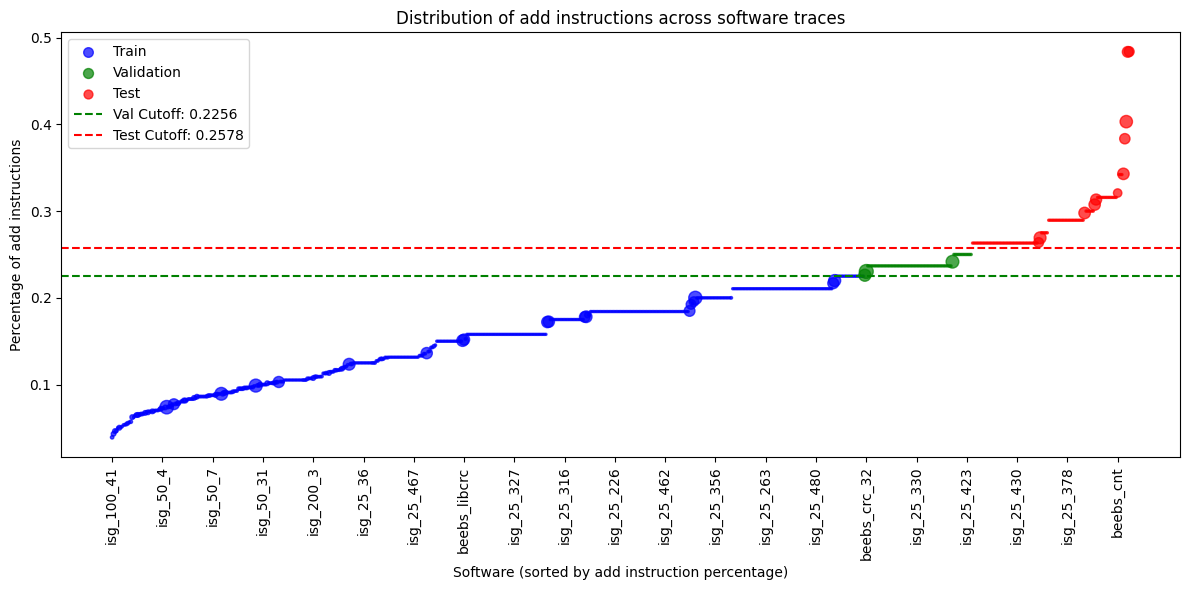

In [20]:
# Step 1: Calculate add instruction percentages
add_pct_dict = {}
for sw, indict in count_dict.items():
    total_instructions = np.sum(np.array(list(indict.values())))
    if total_instructions > 0:
        pct = sum([indict.get(ins, 0) for ins in ["add", "addi", "c.add", "c.addi"]]) / total_instructions
        add_pct_dict[sw] = pct
    else:
        add_pct_dict[sw] = 0

# Step 2: Find optimal split (adjust target_split as needed)
target_split = (0.7, 0.1, 0.2)  # 70-10-20 split
dataset_dict, cutoffs = get_optimal_split(
    count_dict, target_split=target_split
)

# Step 3: Print analysis
train_sw, val_sw, test_sw = dataset_dict["train"], dataset_dict["val"], dataset_dict["test"]
analyze_split(train_sw, val_sw, test_sw, count_dict, cutoffs)

# Step 4: Plot distribution (optional)
plot_distribution(count_dict, add_pct_dict, train_sw, val_sw, test_sw, cutoffs)

## Building the dataset

Now that we have the split, we need to build the dataset itself to be compatible with NeMo

In [3]:
#dw.genDatasetNemo(dataset_dict, name="demo")
#dw.genDatasetFairseq(dataset_dict, name="fairseq")

Dataset 'debug' generated successfully in /home/eduemat/chipwhisperer_lab/datasets/debug
Manifests created at /home/eduemat/chipwhisperer_lab/datasets/debug/manifest_*.json


# Noise Metrics

In [14]:
datgen = DataGenerator()

# Program FGPA with ibex and connect Chipwhisperer
try:
    icw.disconnect()
except:
    pass

bitstream = "lowrisc_ibex_demo_system_512KRAM.bit"

icw = IbexChipWhisperer()
icw.program_fpga(bitstream=bitstream)
icw.connect()

USBErrorIO: LIBUSB_ERROR_IO [-1]

In [ ]:
software = "beebs_compress_test"
trace_list = []

for i in range(20):
    datgen.generate_data(software, icw, force=True, save=False)
    
    trace = icw.scope.get_last_trace()

    trace_list.append(trace)

In [ ]:
avg = np.mean(trace_list, axis=0)
diffs = [trace - avg for trace in trace_list]
plt.plot(list(range(len(avg))), avg)

In [ ]:
# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create a colormap for the different traces
colors = plt.cm.rainbow(np.linspace(0, 1, len(trace_list)))

# Plot each difference as a scatter plot with a different color
for i, diff in enumerate(diffs):
    plt.scatter(list(range(len(diff))), diff, s=10, color=colors[i], alpha=0.7, label=f'Trace {i+1} diff')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Difference from Average')
plt.title('Differences of Individual Traces from Average')

# Add legend but make it compact
plt.legend(loc='upper right', fontsize='small', ncol=2)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 2]})

# Colors for individual KDE plots
colors = plt.cm.rainbow(np.linspace(0, 1, len(diffs)))

# Plot 1: Individual KDE plots
for i, diff in enumerate(diffs):
    sns.kdeplot(diff, ax=axs[0], color=colors[i], alpha=0.1, label=f'Trace {i+1}', fill=True, linewidth=1.5)

axs[0].set_title('KDE Plot for Each Trace Difference')
axs[0].set_xlabel('Difference from Average')
axs[0].set_ylabel('Density')
axs[0].legend(loc='upper right', fontsize='small', ncol=2)

# Plot 2: Aggregated KDE plot with Gaussian overlay
# Flatten all differences into a single array
all_diffs = np.concatenate(diffs)

# Plot the aggregated KDE
sns.kdeplot(all_diffs, ax=axs[1], color='blue', label='Aggregated KDE', linewidth=2)

# Calculate mean and std for Gaussian overlay
mean = np.mean(all_diffs)
std = np.std(all_diffs)

# Create x values for plotting the Gaussian
x = np.linspace(min(all_diffs), max(all_diffs), 1000)

# Calculate Gaussian distribution values
gaussian = stats.norm.pdf(x, mean, std)

# Plot the Gaussian overlay
axs[1].plot(x, gaussian, 'r--', linewidth=2, label=f'Gaussian (μ={mean:.3f}, σ={std:.3f})')

# Add vertical line at mean
axs[1].axvline(mean, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Add some statistics to the plot
stats_text = (f'Mean: {mean:.3f}\n'
              f'Std Dev: {std:.3f}\n'
              f'Skewness: {stats.skew(all_diffs):.3f}\n'
              f'Kurtosis: {stats.kurtosis(all_diffs):.3f}')

axs[1].text(0.02, 0.95, stats_text, transform=axs[1].transAxes, 
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            verticalalignment='top')

axs[1].set_title('Aggregated KDE Plot with Gaussian Overlay')
axs[1].set_xlabel('Difference from Average')
axs[1].set_ylabel('Density')
axs[1].legend(loc='upper right')

# Add grid for better readability
axs[0].grid(True, alpha=0.3)
axs[1].grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

With a very high kurtosis, and occasional systematic areas with extreme outliers, it is safe to say we cannot treat the noise as Gaussian.

In [ ]:
def snr(dat):
    """
    Calculate pointwise SNR defined as mean/std at each point
    
    Parameters:
    dat : array-like
        Input data, with shape (n_traces, n_timepoints)
        
    Returns:
    numpy.ndarray
        Pointwise SNR values
    """
    dat = np.asanyarray(dat)
    mu = dat.mean(0)
    sd = dat.std(axis=0)
    return np.where(sd == 0, 0, mu**2/sd**2)

In [ ]:
# Calculate pointwise SNR
pw_snr = snr(trace_list)
overall_snr = np.mean(pw_snr)

# Calculate SNR threshold for low SNR plot
low_snr_threshold = 10

# Create figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Full SNR range
axs[0].plot(pw_snr, 'b-', linewidth=2)
axs[0].axhline(y=overall_snr, color='r', linestyle='--', 
              label=f'Overall SNR: {overall_snr:.2f}')

# Add marker for maximum and minimum SNR
max_snr_idx = np.argmax(pw_snr)
min_snr_idx = np.argmin(pw_snr)
axs[0].plot(max_snr_idx, pw_snr[max_snr_idx], 'go', markersize=8, 
           label=f'Max SNR: {pw_snr[max_snr_idx]:.2f}')
axs[0].plot(min_snr_idx, pw_snr[min_snr_idx], 'ro', markersize=8,
           label=f'Min SNR: {pw_snr[min_snr_idx]:.2f}')

# Add shading for low SNR regions
low_snr_mask = pw_snr < low_snr_threshold
if np.any(low_snr_mask):
    axs[0].fill_between(range(len(pw_snr)), 0, pw_snr, where=low_snr_mask, 
                       color='red', alpha=0.3, label=f'SNR < {low_snr_threshold:.2f}')

axs[0].set_title('Pointwise SNR (Full Range)')
axs[0].set_xlabel('Sample Point')
axs[0].set_ylabel(r'SNR $(\mu^2/\sigma^2)$')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Low SNR areas only
# Set y-limit to focus on low SNR values
y_max = min(low_snr_threshold * 2, overall_snr)

axs[1].plot(pw_snr, 'b,', linewidth=2)
axs[1].axhline(y=low_snr_threshold, color='r', linestyle='--',
              label=f'Low SNR Threshold: {low_snr_threshold:.2f}')

# Highlight low SNR regions
axs[1].fill_between(range(len(pw_snr)), 0, pw_snr, where=low_snr_mask,
                   color='red', alpha=0.3)

# Find the lowest 5 SNR points
lowest_indices = np.argsort(pw_snr)[:5]
for idx in lowest_indices:
    axs[1].plot(idx, pw_snr[idx], 'ro', markersize=6)
    axs[1].annotate(f'{pw_snr[idx]:.2f}', (idx, pw_snr[idx]), 
                   xytext=(5, 5), textcoords='offset points')

axs[1].set_title('Low SNR Areas (Zoomed)')
axs[1].set_xlabel('Sample Point')
axs[1].set_ylabel(r'SNR $(\mu^2/\sigma^2)$')
axs[1].set_ylim(0, y_max)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistics
print(f"Overall SNR: {overall_snr:.4f}")
print(f"Maximum SNR: {np.max(pw_snr):.4f} at point {max_snr_idx}")
print(f"Minimum SNR: {np.min(pw_snr):.4f} at point {min_snr_idx}")
print(f"Low SNR threshold: {low_snr_threshold:.4f}")
print(f"Number of points below threshold: {np.sum(low_snr_mask)}")